In [1]:
import pandas as pd

# Загрузка данных
train_df = pd.read_csv('training.csv')
test_df = pd.read_csv('test.csv')
val_df = pd.read_csv('validation.csv')

# Информация о данных
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Validation shape:", val_df.shape)

# Вывод первых строк
print(train_df.head())

Train shape: (16000, 2)
Test shape: (2000, 2)
Validation shape: (2000, 2)
                                                text  label
0                            i didnt feel humiliated      0
1  i can go from feeling so hopeless to so damned...      0
2   im grabbing a minute to post i feel greedy wrong      3
3  i am ever feeling nostalgic about the fireplac...      2
4                               i am feeling grouchy      3


Пропуски в тренировочном наборе:
text     0
label    0
dtype: int64
Распределение классов в тренировочном наборе:
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64


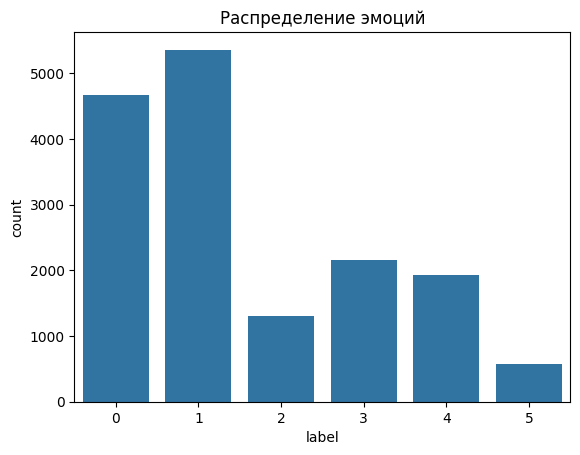

In [2]:
# Проверка пропусков
print("Пропуски в тренировочном наборе:")
print(train_df.isnull().sum())

# Распределение классов
print("Распределение классов в тренировочном наборе:")
print(train_df['label'].value_counts())

# Визуализация распределения классов
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train_df)
plt.title("Распределение эмоций")
plt.show()

In [3]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Текстовая предобработка
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Удаление ссылок
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Удаление цифр и символов
    text = text.lower()  # Приведение к нижнему регистру
    return text

# Применение предобработки
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

# TF-IDF векторы
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(train_df['text']).toarray()

# Кодирование меток
le = LabelEncoder()
y = le.fit_transform(train_df['label'])

# Разделение данных
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Обучение модели
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Оценка модели
y_pred = lr_model.predict(X_valid)
print("Accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred))

Accuracy: 0.8453125
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       946
           1       0.79      0.96      0.87      1021
           2       0.88      0.57      0.69       296
           3       0.90      0.78      0.84       427
           4       0.85      0.71      0.77       397
           5       0.88      0.43      0.58       113

    accuracy                           0.85      3200
   macro avg       0.86      0.73      0.78      3200
weighted avg       0.85      0.85      0.84      3200



In [5]:
from sklearn.svm import SVC

# Обучение модели SVM
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Оценка модели
y_pred_svm = svm_model.predict(X_valid)
print("Accuracy (SVM):", accuracy_score(y_valid, y_pred_svm))
print(classification_report(y_valid, y_pred_svm))

Accuracy (SVM): 0.8790625
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       946
           1       0.86      0.94      0.90      1021
           2       0.84      0.69      0.76       296
           3       0.91      0.86      0.88       427
           4       0.84      0.83      0.84       397
           5       0.82      0.65      0.72       113

    accuracy                           0.88      3200
   macro avg       0.86      0.82      0.84      3200
weighted avg       0.88      0.88      0.88      3200



In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Подготовка данных для LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train_df['text'])

X_train_seq = tokenizer.texts_to_sequences(train_df['text'])
X_valid_seq = tokenizer.texts_to_sequences(test_df['text'])

X_train_seq = pad_sequences(X_train_seq, maxlen=100)
X_valid_seq = pad_sequences(X_valid_seq, maxlen=100)

# Создание модели LSTM
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(64))
model.add(Dense(6, activation='softmax'))  # 6 классов эмоций

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Обучение модели
history = model.fit(X_train_seq, y, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.4035 - loss: 1.4824 - val_accuracy: 0.8219 - val_loss: 0.5597
Epoch 2/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.8786 - loss: 0.3767 - val_accuracy: 0.9019 - val_loss: 0.2995
Epoch 3/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9505 - loss: 0.1471 - val_accuracy: 0.9087 - val_loss: 0.2622
Epoch 4/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9691 - loss: 0.0932 - val_accuracy: 0.9112 - val_loss: 0.2898
Epoch 5/5
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.9779 - loss: 0.0670 - val_accuracy: 0.9191 - val_loss: 0.2606
